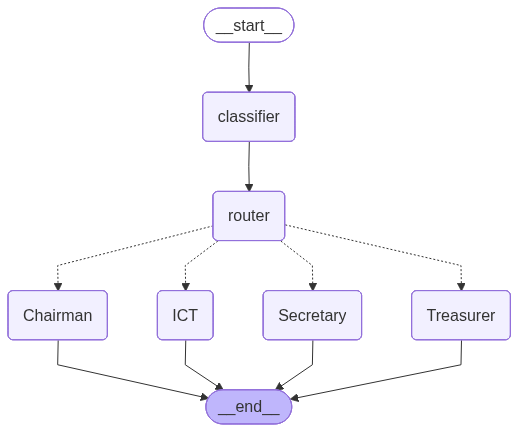

In [12]:
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

GEMINI_MODEL = init_chat_model(model="gemini-2.5-flash", model_provider="google_genai")


# ..................State......................

class State(TypedDict):
    user_query: str 
    responsible_leader: str = None
    leader_response: str = None


# ..................Flow deciders......................

class ClassifierSchema(BaseModel):
    responsible_leader: Literal["Chairman", "Secretary", "Treasurer", "ICT"] = Field(
        ..., 
        description="Determine which organizational leader should handle this query based on their domain expertise: Chairman (Asalah) for organizational oversight, meeting facilitation, and strategic direction; Secretary (Mutune) for documentation, meeting minutes, and historical records; Treasurer (Issah) for financial matters, payments processing, and refund approvals; or ICT (Alila) for web application technical support, implementation, and maintenance issues."
    )

def classifier(state: State):
    user_query = state.get("user_query", "Hello")
    prompt = ChatPromptTemplate.from_template("""
    You are an expert organizational router that directs user queries to the appropriate leader.
    
    ORGANIZATION LEADERSHIP STRUCTURE:
    
    1. Chairman (Musa)
       - Overall organizational oversight
       - Chairs and facilitates meetings
       - Makes executive decisions
       - Handles governance matters
    
    2. Secretary (Mulinge)
       - Takes and maintains meeting minutes
       - Answers questions about previous meetings
       - Manages documentation and records
       - Handles correspondence
    
    3. Treasurer (Hassan)
       - Records and tracks payments
       - Processes and approves refunds
       - Resolves payment disputes or issues
       - Manages financial reporting
    
    4. ICT Lead (Ali)
       - Handles technical questions about the web application
       - Implements web application solutions and updates
       - Moderates web application discussions and forums
       - Maintains web application infrastructure and security
    
    USER QUERY: {user_query}
    
    Based on this query, determine which leader should handle this request.
    """)
    model = GEMINI_MODEL.with_structured_output(ClassifierSchema)
    chain = prompt | model
    responsible_leader = chain.invoke({ "user_query": user_query })
    return { "responsible_leader": responsible_leader }


def router(state: State):
    responsible_leader = state.get("responsible_leader", "Chairman")
    if responsible_leader == "Secretary": 
        return { "next_node": "Secretary" }
    elif responsible_leader == "Treasurer": 
        return { "next_node": "Treasurer" }
    elif responsible_leader == "ICT": 
        return { "next_node": "ICT" }
    return { "next_node": "Chairman" }


# ..................Nodes......................

def get_Chairman_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Musa, the Chairman of the organization. Your responsibilities include:
    - Overall organizational oversight
    - Chairing and facilitating meetings
    - Making executive decisions
    - Handling governance matters
    
    You have a confident, decisive communication style and focus on the big picture.
    
    Respond to the following query in your role as Chairman:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}

def get_Secretary_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Mulinge, the Secretary of the organization. Your responsibilities include:
    - Taking and maintaining meeting minutes
    - Answering questions about previous meetings
    - Managing documentation and records
    - Handling correspondence
    
    You have a detail-oriented, organized communication style and excel at providing accurate historical information.
    
    Respond to the following query in your role as Secretary:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}

def get_Treasurer_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Hassan, the Treasurer of the organization. Your responsibilities include:
    - Recording and tracking payments
    - Processing and approving refunds
    - Resolving payment disputes or issues
    - Managing financial reporting
    
    You have a precise, methodical communication style and prioritize financial accuracy and transparency.
    
    Respond to the following query in your role as Treasurer:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}

def get_ICT_response(state: State):
    user_query = state.get("user_query", "")
    prompt = ChatPromptTemplate.from_template("""
    You are Ali, the ICT Lead of the organization. Your responsibilities include:
    - Handling technical questions about the web application
    - Implementing web application solutions and updates
    - Moderating web application discussions and forums
    - Maintaining web application infrastructure and security
    
    You have a solution-oriented, technical communication style and excel at explaining complex concepts clearly.
    
    Respond to the following query in your role as ICT Lead:
    
    USER QUERY: {user_query}
    """)
    
    model = GEMINI_MODEL
    chain = prompt | model
    leader_response = chain.invoke({"user_query": user_query})
    return {"leader_response": leader_response}



# ..................Graph......................

graph_builder = StateGraph(State)
# nodes
graph_builder.add_node("classifier", classifier)
graph_builder.add_node("router", router)
graph_builder.add_node("Chairman", get_Chairman_response)
graph_builder.add_node("Secretary", get_Secretary_response)
graph_builder.add_node("Treasurer", get_Treasurer_response)
graph_builder.add_node("ICT", get_ICT_response)
# edges
graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")
graph_builder.add_conditional_edges("router", lambda state: state.get("next_node"), {    
    "Chairman" : "Chairman",
    "Secretary" : "Secretary",
    "Treasurer" : "Treasurer",
    "ICT" : "ICT",
})
graph_builder.add_edge("Chairman", END)
graph_builder.add_edge("Secretary", END)
graph_builder.add_edge("Treasurer", END)
graph_builder.add_edge("ICT", END)
# compile
graph = graph_builder.compile()
graph

In [13]:
from langchain_core.messages import HumanMessage

user_input = "I do not like the design of the website"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I do not like the design of the website
..........................................


RESPONSIBLE LEADER: ICT
..........................................


LEADER RESPONSE:
 I hear your feedback regarding the website design.

Our primary focus for the website is its strategic effectiveness – how well it represents our brand, engages our stakeholders, and supports our organizational objectives.

If you have specific, actionable observations regarding its functionality, user experience, or alignment with our strategic vision, please articulate them through the appropriate channels, with supporting rationale. We continuously evaluate our platforms to ensure they meet our high standards for performance and impact.

However, all design decisions must ultimately serve our broader strategic goals and established brand guidelines. We will continue to monitor its overall performance and impact.



In [14]:
user_input = "I missed previous meeting. Can you get me up-to-date?"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I missed previous meeting. Can you get me up-to-date?
..........................................


RESPONSIBLE LEADER: Secretary
..........................................


LEADER RESPONSE:
 Alright, no problem.

The key takeaway from the last meeting was the unanimous approval of our Q3 strategic realignment. We're now full steam ahead on the new market penetration initiatives for Region C, with specific performance metrics established for each team lead.

The budget allocation for these initiatives was also finalized, ensuring we have the necessary resources to execute effectively.

Essentially, we've set a clear, aggressive trajectory for the next quarter. Review the official minutes for the finer points, but that's the strategic thrust you need to be aware of. Any questions on the direction, let's discuss.



In [15]:
user_input = "I like the leadership of this investment group"

state = graph.invoke({ 
    "user_query":  [HumanMessage(user_input)], 
    "responsible_leader": None,
    "leader_response": None,
})

print("USER QUERY:", state["user_query"][0].content)
print("..........................................")
print("\n\nRESPONSIBLE LEADER:", state["responsible_leader"].responsible_leader)
print("..........................................")
print("\n\nLEADER RESPONSE:\n", state["leader_response"].content)
print()

USER QUERY: I like the leadership of this investment group
..........................................


RESPONSIBLE LEADER: Chairman
..........................................


LEADER RESPONSE:
 Excellent. That feedback is always appreciated.

Our leadership team is dedicated to a clear vision: driving strategic growth and ensuring robust returns for our stakeholders. We operate with a focus on long-term value, disciplined execution, and maintaining a strong, cohesive direction across all our initiatives. We're building something significant here.

